# Tutorial: **δHBV 1.1p**

---

This notebook demonstrates training and forward simulation with the δHBV 1.1p model developed by [Yalan Song et al. (2025)](https://doi.org/10.22541/essoar.172304428.82707157/v2). A pre-trained model is provided for those who only wish to run the model forward.

For explanation of model structure, methodologies, data, and performance metrics, please refer to Song's publication [below](#publication). If you find this code is useful in your own work, please include the aforementioned citation.

**Note**: If you are new to the dMG framework, we suggest first looking at our [δHBV 1.0 tutorial](./../hydrology/example_dhbv.ipynb).

<br>

### Before Running:
- **Environment**: See [setup.md](./../../docs/setup.md) for ENV setup. dMG must be installed with dependencies + hydrodl2 to run this notebook.

- **Model**: Download pretrained δHBV 1.1p model weights from [AWS](https://mhpi-spatial.s3.us-east-2.amazonaws.com/mhpi-release/models/dhbv_1_1p_trained.zip). Then update the model config:

    - In [`./generic_deltamodel/example/conf/config_dhbv_1_1p.yaml`](./../conf/config_dhbv_1_1p.yaml), update *trained_model* with your path to the parent directory containing both trained model weights `dhbv_1_1p_ep50.pt` (or *Ep100*) **and** normalization file `normalization_statistics.json`.
    - **Note**: make sure this path includes the last closing forward slash: e.g., `./your/path/to/model/`.

- **Data**: Download the CAMELS data extraction from [AWS](https://mhpi-spatial.s3.us-east-2.amazonaws.com/mhpi-release/camels/camels_data.zip). Then, updated the data configs:

    - In [`./generic_deltamodel/example/conf/observations/camels_531.yaml`](./../conf/observations/camels_531.yaml) and [`camels_671.yaml`](./../conf/observations/camels_671.yaml), update...
        1. *data_path* with `camels_dataset` path,
        2. *gage_info* with `gage_ids.npy` path,
        3. *subset_path* with `531_subset.txt` path (camels_531 only).

    - The full 671-basin or 531-basin CAMELS datasets can be selected by setting `observations: camels_671` or `camels_531` in the model config, respectively.

- **Hardware**: The NNs used in this model require CUDA support only available with Nvidia GPUs. For those without access, T4 GPUs can be used when running this notebook with dMG on [Google Colab](https://colab.research.google.com/).

<br>

### Publication:

*Yalan Song, Kamlesh Sawadekar, Jonathan M Frame, Ming Pan, Martyn Clark, Wouter J M Knoben, Andrew W Wood, Trupesh Patel, Chaopeng Shen. "Physics-informed, Differentiable Hydrologic  Models for Capturing Unseen Extreme Events." ESS Open Archive (2025). https://doi.org/10.22541/essoar.172304428.82707157/v2.*

<br>

### Issues:
For questions, concerns, bugs, etc., please reach out by posting an [issue](https://github.com/mhpi/generic_deltamodel/issues).

---


<br>

## 1. Forward δHBV 1.1p

After completing [these](#before-running) steps, forward δHBV 1.1p with the code block below.

Note:
- The settings defined in the config `./generic_deltamodel/example/conf/config_dhbv_1_1p.yaml` are set to replicate benchmark performance on 531 CAMELS basins.
- The first year (`warm_up` in the config, default is 365 days) of the inference period is used for initializing HBV's internal states (water storages) and is, therefore, excluded from the model's prediction output.

### 1.1 Demonstration

In [1]:
def print_dataset_info(dataset):
    print("\n\033[1mDataset Inputs\033[0m") 
    # Header row
    print(f"{'Dataset key':<15}{'Shape':<20}{'Description'}")
    print("-" * 60) 
    # Rows
    print(f"{'x_phy':<15}{str(tuple(dataset['x_phy'].size())):<20} # [time, basin, forcing_features]")
    print(f"{'c_phy':<15}{str(tuple(dataset['c_phy'].size())):<20} # [basin, attr_features] (no physical attributes here)")
    print(f"{'x_nn':<15}{str(tuple(dataset['x_nn'].size())):<20} # [time, basin, nn_forcing_features]")
    print(f"{'c_nn':<15}{str(tuple(dataset['c_nn'].size())):<20} # [basin, nn_attr_features]")
    print(f"{'xc_nn_norm':<15}{str(tuple(dataset['xc_nn_norm'].size())):<20} # [time, basin, combined_features]")
    print(f"{'target':<15}{str(tuple(dataset['target'].size())):<20} # [time, basin, 1] observed streamflow") 
    print("\nSample of target tensor (first 5 timesteps, first basin):")
    print(f"{dataset['target'][:5, 0, 0]}")


In [2]:
import sys
sys.path.append('../../') 
from src.dmg import ModelHandler 
from src.dmg.core.utils import import_data_loader, print_config, set_randomseed
from example import load_config 
#------------------------------------------#
# Define model settings here.
CONFIG_PATH = '../example/conf/config_dhbv_1_1p.yaml'
#------------------------------------------#

# 1. Load configuration dictionary of model parameters and options.
config = load_config(CONFIG_PATH)
config['mode'] = 'simulation'
print_config(config)
print("Config Keys:", config.keys())

# Set random seed for reproducibility.
set_randomseed(config['random_seed'])

# 2. Initialize the differentiable HBV 1.1p model (LSTM + HBV 1.1p).
model = ModelHandler(config, verbose=True) # model key is ['Hbv_1_1p'] 
nn_model = model.model_dict["Hbv_1_1p"].nn_model
print("NN model class:", type(nn_model).__name__)
print("Model Keys:", model.model_dict.keys()) 
print("Model Keys:", model.model_dict['Hbv_1_1p'])

# 3. Load and initialize a dataset dictionary of NN and HBV model inputs.
data_loader_cls = import_data_loader(config['data_loader'])
data_loader = data_loader_cls(config, test_split=False, overwrite=False)
print_dataset_info(data_loader.dataset) 


Current Configuration
  Experiment Mode:    simulation          
  Model 1:            Hbv_1_1p            

Data Loader
  Data Source:        camels_531          
  Simulation Range :  2012/10/01          2014/09/30          

Model Parameters
  Train Epochs:       50                  Batch Size:         100                 
  Dropout:            0.5                 Hidden Size:        256                 
  Warmup:             365                 Concurrent Models:  16                  
  Loss Fn:            NseBatchLoss        

Machine
  Use Device:         cuda:0              

Config Keys: dict_keys(['mode', 'random_seed', 'device', 'gpu_id', 'data_loader', 'data_sampler', 'trainer', 'save_path', 'trained_model', 'train', 'test', 'simulation', 'loss_function', 'delta_model', 'observations', 'dtype', 'train_time', 'test_time', 'sim_time', 'experiment_time', 'all_time', 'multimodel_type', 'model_path', 'out_path'])
NN model class: CudnnLstmModel
Model Keys: dict_keys(['Hbv_1_1p'])

In [3]:
import numpy as np
import pandas as pd

def compute_bias_correction_from_dataset(
    daymet_tensor, gefs_df, timesteps, basin_idx, window=15, method="scalar"
):
    """
    Compute bias correction factors (scalar or CDF-based) for GEFS forcings
    using Daymet climatology in a moving DOY window.

    Parameters
    ----------
    daymet_tensor : torch.Tensor [time, basin, 3]
        Historical Daymet forcings from the dataset.
    gefs_df : pd.DataFrame
        GEFS historical forcings with columns: date, prcp, tmean, pet.
    timesteps : np.ndarray
        Daily time axis corresponding to Daymet.
    basin_idx : int
        Basin index to select from Daymet tensor.
    window : int
        ±days around each DOY to compute moving-window stats.
    method : str, {"scalar", "cdf"}
        Bias correction method:
        - "scalar": mean ratio (current method)
        - "cdf": quantile mapping / CDF matching

    Returns
    -------
    dict
        A dictionary of corrections per variable.
        For "scalar" → corrections[var][doy] = scalar value
        For "cdf" → corrections[var][doy] = (p_grid, mapped_values)
    """
    # Convert Daymet tensor → DataFrame
    df_daymet = pd.DataFrame({
        "date": pd.to_datetime(timesteps),
        "prcp": daymet_tensor[:, basin_idx, 0].detach().cpu().numpy(),
        "tmean": daymet_tensor[:, basin_idx, 1].detach().cpu().numpy(),
        "pet": daymet_tensor[:, basin_idx, 2].detach().cpu().numpy(),
    })
    df_daymet["doy"] = df_daymet["date"].dt.dayofyear

    gefs_df = gefs_df.copy()
    gefs_df["doy"] = gefs_df["date"].dt.dayofyear

    corrections = {v: {} for v in ["prcp","tmean","pet"]}

    for var in ["prcp","tmean","pet"]:
        for doy in range(1, 366):
            mask_d = (df_daymet["doy"] - doy).abs() <= window
            mask_g = (gefs_df["doy"] - doy).abs() <= window

            vals_d = df_daymet.loc[mask_d, var].dropna()
            vals_g = gefs_df.loc[mask_g, var].dropna()

            if len(vals_d) < 10 or len(vals_g) < 10:
                continue

            if method == "scalar":
                mean_d = vals_d.mean()
                mean_g = vals_g.mean()
                corrections[var][doy] = mean_d / mean_g if mean_g > 1e-6 else 1.0

            elif method == "cdf":
                # Create percentile grid (0–100)
                p_grid = np.linspace(0, 100, 101)
                q_daymet = np.percentile(vals_d, p_grid)
                q_gefs = np.percentile(vals_g, p_grid)
                corrections[var][doy] = (q_gefs, q_daymet)  # (x_in, x_out)
            else:
                raise ValueError(f"Unknown correction method '{method}'")

    return corrections


def pre_processing(df, corrections, method="scalar"):
    """
    Apply bias correction (scalar or CDF) to GEFS forecast DataFrame.
    """
    df = df.copy()
    df["doy"] = df["date"].dt.dayofyear

    for var in ["prcp", "tmean", "pet"]:
        if method == "scalar":
            df[var] *= df["doy"].map(lambda d: corrections[var].get(d, 1.0))

        elif method == "cdf":
            corrected_vals = []
            for i, row in df.iterrows():
                doy = row["doy"]
                val = row[var]
                if doy not in corrections[var]:
                    corrected_vals.append(val)
                    continue
                q_in, q_out = corrections[var][doy]
                # interpolate within empirical CDFs
                corrected_vals.append(np.interp(val, q_in, q_out))
            df[var] = corrected_vals

        else:
            raise ValueError(f"Unknown correction method '{method}'")

    return df


def post_processing(sim_pre_GEFS, ens_preds): # post processing
    """
    Apply a constant offset correction so that the first forecasted streamflow
    connects smoothly with the last simulated (Daymet) streamflow.

    Parameters
    ----------
    sim_pre_GEFS : np.ndarray
        1D array of simulated streamflow before the forecast period (from HBV using Daymet).
    ens_preds : np.ndarray
        2D array of ensemble forecasts with shape (N_ENSEMBLES, FORECAST_LENGTH).

    Returns
    -------
    np.ndarray
        Offset-corrected ensemble forecasts of the same shape.
    """
    Q_sim_end = sim_pre_GEFS[-1]  # last simulated streamflow value
    ens_preds_corrected = []

    for ens in ens_preds:
        offset = Q_sim_end - ens[0]          # compute offset
        ens_corrected = np.maximum(ens + offset, 0.0)  # apply and ensure non-negative
        ens_preds_corrected.append(ens_corrected)

    return np.array(ens_preds_corrected)


In [14]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

def get_parameters_from_model(dpl_model, data, n_par, mu, device="cpu"):
    nn_model = dpl_model.nn_model
    print("nn model is", dpl_model.nn_model)
    print("xc_nn_norm shape before NN:", data["xc_nn_norm"].shape)
    xc_nn = data["xc_nn_norm"].to(device) # make sure it is on GPU

    with torch.no_grad():
        out = nn_model(xc_nn)   # only time-series input
        if isinstance(out, (tuple, list)):
            out = out[0]
 
        T, B, F = out.shape # zhennan comments: T: time dimension, B: # of basins, F: number of output features
        print(f"Output shape from NN: T={T}, B={B}, F={F}") # 715, 1, 226
        
        if F == n_par * mu + 2: # F = 14*16 + 2 -> 226
            flat = out[:, :, : n_par * mu]
            pars = flat.view(T, B, n_par, mu).to(device)
            rts  = out[-1, :, n_par * mu : n_par * mu + 2].to(device)  
        else:
            raise RuntimeError(
                f"Unexpected feature size {F}, expected {n_par}, {n_par*mu}, or {n_par*mu+2}"
            )
            
        # sanity check
        print(f"pars shape: {pars.shape}") # [715, 1, 14, 16]
        print(f"rts shape: {rts.shape}") # [1, 2]
                 
    return pars, rts # pars: [T, B, n_par, mu], and rts: [B, 2]

def obtain_gage_name(GAGE_NAME_PATH, gage_id): 
    gage_names = pd.read_csv(
    GAGE_NAME_PATH,
    sep=";",
    dtype={"gauge_id": str}
    ) 
    gage_names['gauge_id'] = gage_names['gauge_id'].str.lstrip('0') 
    match = gage_names.loc[gage_names['gauge_id'] == str(gage_id), 'gauge_name']
    if match.empty:
        raise ValueError(f"GAGE_ID {gage_id} not found in {GAGE_NAME_PATH}")
    else:
        gage_name = match.values[0]
    return gage_name

def plot_ensemble_forecast(GAGE_NAME_PATH, gage_id, start_date, obs, sim, ens_preds, history_len, save_path=None):
    """
    Plot 2 months history + 15-day forecast:
      - Observed (black)
      - Simulation (red) for history
      - 5 ensembles in distinct colors for forecast
    """ 
    print("the length is here", len(sim), len(obs))
    ## Get the gage name first
    gage_name = obtain_gage_name(GAGE_NAME_PATH, gage_id)
    
    HORIZON = ens_preds.shape[1]
    start_date = pd.to_datetime(start_date)
    dates_obs = pd.date_range(
        start=start_date - pd.Timedelta(days=history_len),
        periods=history_len + HORIZON,
    )
    dates_sim = pd.date_range(
        start=start_date - pd.Timedelta(days=history_len),
        periods=history_len+1,
    ) 
 
    # Pad ensembles for plotting (only forecast period valid)
    padded_ensembles = np.full((ens_preds.shape[0], history_len + HORIZON), np.nan)
    padded_ensembles[:, history_len:] = ens_preds

    # Plot 
    plt.figure(figsize=(12, 6)) 
    plt.plot(dates_obs, obs, "k-", lw=2, marker="*", label="Observed") 
    plt.plot(dates_sim, sim, "r-", lw=1.5, marker="o", label="Simulation")

    # Ensembles in distinct colors
    colors = cm.tab10.colors  # 10 distinct colors
    for i in range(ens_preds.shape[0]):
        plt.plot(
            dates_obs,
            padded_ensembles[i],
            lw=1.5,
            color=colors[i % len(colors)],
            label=f"Ensemble {i+1}",
        )

    # Shading for history vs forecast
    plt.axvspan(dates_obs[0], dates_obs[history_len], color="gray", alpha=0.1, label="Pre-GEFS Simulation")
    plt.axvspan(dates_obs[history_len], dates_obs[-1], color="orange", alpha=0.1, label="GEFS Forecast")

    plt.title(f"GEFS Forecast — Gage {gage_id} ({gage_name})")
    plt.xlabel("Date")
    plt.ylabel("Streamflow (mm/day)")
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc="upper center", ncol=int(np.ceil(len(labels)/4))) 
    plt.grid(True, linestyle="--", linewidth=0.7, alpha=0.7)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

def to_time_first(x_torch):
    return x_torch.permute(1, 0, 2).float().to(device)  # [T,B,F]

def safe_minmax(tensor):
    """Return min and max ignoring NaNs."""
    if tensor.numel() == 0:
        return np.nan, np.nan
    safe_min = torch.where(torch.isnan(tensor),
                           torch.tensor(float("inf"), device=tensor.device),
                           tensor)
    min_val = float(torch.min(safe_min))
    safe_max = torch.where(torch.isnan(tensor),
                           torch.tensor(float("-inf"), device=tensor.device),
                           tensor)
    max_val = float(torch.max(safe_max))
    return min_val, max_val

def checknans(warm_states): 
    for name, st in zip(["sp","mw","sm","suz","slz"], warm_states):
        smin, smax = safe_minmax(st)
        print(name, "nan#", torch.isnan(st).sum().item(),
              "min", smin, "max", smax)
        
def GEFSdataErrorCheck(idx_list, fc_block, horizon, start_date, showblock=False):
    if not idx_list: raise ValueError(f"Starting GEFS date {start_date.date()} not exist!")
    if len(fc_block) < horizon: raise ValueError("Extracted GEFS forcing not enough!")
    if showblock:
        print("\n========= GEFS Forecast Block (NO ERROR) =========")
        print(fc_block.to_string(index=False))
         

def run_warm_forecasts(
    hbv, pars_last, rtwts_hist, warm_states,
    gage_id, start_date, horizon, varF,
    N_ENSEMBLES, GEFS_DIR, timesteps, WIDNOW, CORRECTION, device
):
    ens_preds = []
      # will store per-basin correction once

    for ens_id in range(N_ENSEMBLES):
        # ----- Load GEFS forecast for this ensemble -----
        f_path = os.path.join(GEFS_DIR, f"ens0{ens_id+1}", f"{gage_id:08d}.txt")
        if not os.path.exists(f_path):
            raise ValueError(f"Missing GEFS file: {f_path}")

        df = pd.read_csv(f_path, sep=r"\s+", header=0)
        df = df.rename(columns={
            "Year": "year", "Mnth": "month", "Day": "day",
            "prcp(mm/day)": "prcp", "tmean(C)": "tmean", "pet(mm/day)": "pet"
        })
        df["date"] = pd.to_datetime(df[["year", "month", "day"]])

        # ----- Extract forecast block -----
        idx_list = df.index[df["date"] == start_date].to_list()
        if not idx_list:
            raise ValueError(f"Start date {start_date} not found in {f_path}")
        fc_block = df.iloc[idx_list[0] : idx_list[0] + horizon]
        GEFSdataErrorCheck(idx_list, fc_block, horizon, start_date)

        # ----- Compute bias correction once (for the first ensemble) -----
        if not CORRECTION:
            bias_corrections = compute_bias_correction_from_dataset(
                dataset["x_phy"], df, timesteps, basin_idx, window=WINDOW, method=CORRECTION  # or "scalar"
            )
            print(f"Bias correction computed for basin {gage_id}") 
            # ----- Apply bias correction -----
            fc_block = pre_processing(fc_block, bias_corrections, method=CORRECTION)

        # ----- Convert forcings to tensor -----
        raw_np = fc_block[varF].to_numpy().astype(np.float32)
        forc_raw = torch.tensor(raw_np[np.newaxis, :, :], dtype=torch.float32, device=device)
        forc_raw[torch.isnan(forc_raw)] = 0.0

        # ----- Run HBV forecast with warm states -----
        with torch.no_grad():
            Qs_fc = hbv(
                x=to_time_first(forc_raw),
                parameters=pars_last,
                staind=staind, tdlst=tdRep,
                mu=nmul,
                muwts=None, rtwts=rtwts_hist,
                bufftime=0,
                outstate=False, instate=True,
                init_states=warm_states,
                routOpt=routing, dydrop=dydrop,
            )

        # ----- Sanity check and store -----
        ens_fc = Qs_fc[:, 0, 0].detach().cpu().numpy()
        if np.isnan(ens_fc).all():
            raise ValueError(f"ens_fc are all NaNs for basin {gage_id}, ensemble {ens_id}!")

        ens_preds.append(ens_fc)

    return np.array(ens_preds)  # shape: (N_ENSEMBLES, horizon)

def selectbasins(RANDOM, SEED):
    if RANDOM:
        random.seed(SEED)
        selected_basins = random.sample(basin_pool, N_BASINS)
        print("Randomly selected basins:", selected_basins)
    else:
        selected_basins = [2046000] #  [1547700]
        print("Fixed selected a basin:", selected_basins)
    return selected_basins

def startid_endid(START_DATE):
    timesteps = Dates(config["simulation"], config["delta_model"]["rho"]).batch_daily_time_range # 730
    sidx = np.where(timesteps == START_DATE)[0][0] # 715
    eidx = sidx + FORECAST # 730
    return sidx, eidx, timesteps

Fixed selected a basin: [2046000]

=== Running forecast for basin 2046000 ===
hist_dict['xc_nn_norm'] shape: torch.Size([715, 1, 38])
nn model is CudnnLstmModel(
  (linear_in): Linear(in_features=38, out_features=256, bias=True)
  (lstm): CudnnLstm()
  (linear_out): Linear(in_features=256, out_features=226, bias=True)
)
xc_nn_norm shape before NN: torch.Size([715, 1, 38])
Output shape from NN: T=715, B=1, F=226
pars shape: torch.Size([715, 1, 14, 16])
rts shape: torch.Size([1, 2])
the length is here 121 135


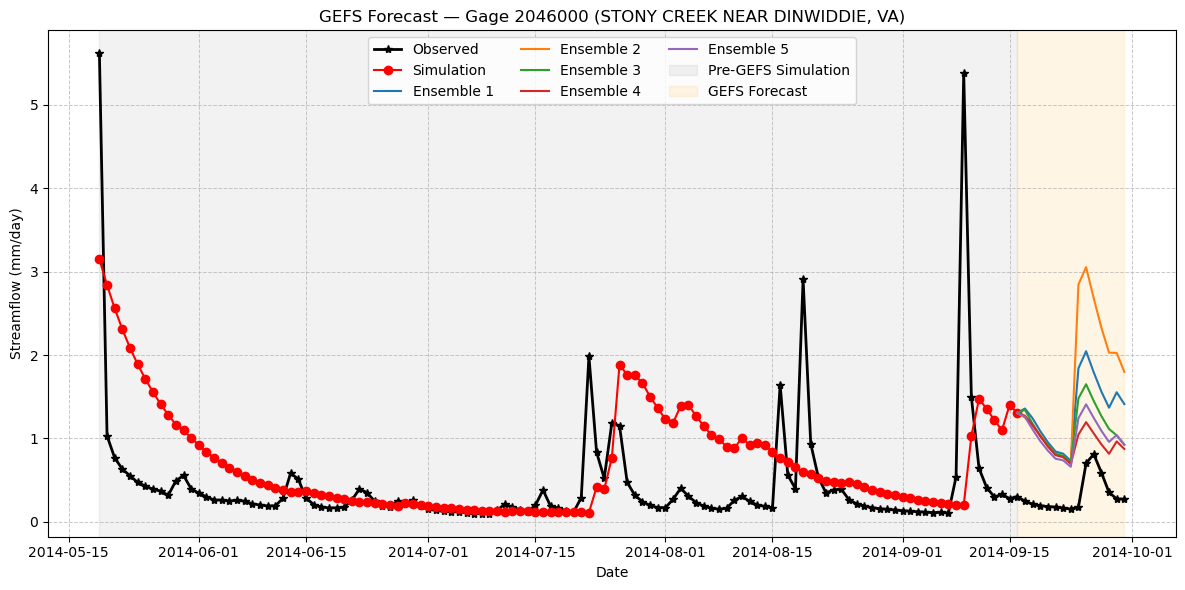

Saved plot for basin 2046000 → figs/GEFS_2046000/GEFS_2046000_scalar_w30.png


In [16]:
import os
import json
import numpy as np
import pandas as pd
import torch
import random
from src.dmg.core.utils import Dates
import helper as hp
from hydrodl2.models.hbv import HBV1_1p as h1pp

# ---------------- Simulation settings ---------------- #
START_DATE     = pd.to_datetime("2014-09-16")
FORECAST       = 15
N_ENSEMBLES    = 5
N_BASINS       = 5   # randomly pick basins
SEED           = 1234  # config["random_seed"]
RANDOM         = False
device         = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
GEFS_DIR       = "/u/st/dr/awwood/aw-ciroh-proj/projects/dl_da/daymet-gefs-camels-gII"
GAGE_NAME_PATH = "/beegfs/projects/aw-ciroh/common/datasets/camels/CAMELS_US/camels_attributes_v2.0/camels_name.txt"
dataset        = data_loader.dataset
WINDOW         = 30 # pre-processing on correcting window (in days)
CORRECTION     = 'scalar'  #  # or 'cdf'

# HBV options
staind   = -1
tdRep    = [1, 3, 13]
VAR_F    = config['delta_model']['phy_model']['forcings']
BUFFTIME = config['delta_model']['phy_model']['warm_up']
routing  = config['delta_model']['phy_model']['routing'] 
dydrop   = config['delta_model']['phy_model']['dy_drop']  
nmul     = config["delta_model"]["phy_model"]["nmul"]

# Plot settings
history_len  = 120

# ---------------- Obtain basin IDs ---------------- #
gage_ids    = np.load(config["observations"]["gage_info"], allow_pickle=True)
subset_file = config["observations"]["subset_path"]
with open(subset_file, "r") as f:
    content = f.read().strip()
gage_ids_subset = json.loads(content) if content.startswith("[") else np.loadtxt(subset_file, dtype=int).tolist()

if config["observations"]["name"] == "camels_671":
    basin_pool = list(gage_ids)
elif config["observations"]["name"] == "camels_531":
    basin_pool = list(gage_ids_subset) 

# ---------------- Select 5 random basins ---------------- #
selected_basins = selectbasins(RANDOM, SEED)
sidx, eidx, timesteps = startid_endid(START_DATE)
hbv = h1pp.HBV().to(device) 

# ---------------- Loop over selected basins ---------------- #
for GAGE_ID in selected_basins:
    print(f"\n=== Running forecast for basin {GAGE_ID} ===")
    basin_idx = basin_pool.index(GAGE_ID) 
    
    # ---------------- Get inputs of all forcings 38 from trained NN ---------------- #
    hist_dict = {
        "xc_nn_norm":dataset["xc_nn_norm"][:sidx, basin_idx:basin_idx+1, :].clone()   
    } # [715, 1, 38] 2years - 15 days = 715 days
    print(f"hist_dict['xc_nn_norm'] shape: {hist_dict['xc_nn_norm'].shape}")
    
    # ---------------- Get parameters from trained NN ---------------- #
    pars_hist, rtwts_hist = get_parameters_from_model(model.model_dict["Hbv_1_1p"], hist_dict, n_par=14, mu=nmul, device=device) # pars: 715, 1, 14, 16    rts: 1, 2
    
    pars_first = pars_hist[:1].repeat(sidx, 1, 1, 1) 
    pars_last = pars_hist[-1:].repeat(FORECAST, 1, 1, 1) 
    
    # --- Warm-up HBV with RAW forcings (Daymet) ---
    with torch.no_grad():
        forc_hist = torch.nan_to_num(dataset["x_phy"][:sidx, basin_idx:basin_idx+1, :3], nan=0.0)
        Qs_hist, sp, mw, sm, suz, slz = hbv(
            x=forc_hist, parameters=pars_first,
            staind=staind, tdlst=tdRep,
            mu=nmul, muwts=None, rtwts=rtwts_hist, bufftime=BUFFTIME,
            outstate=True, instate=False,
            routOpt=routing, dydrop=dydrop,
        )
    warm_states = (sp, mw, sm, suz, slz) # checknans(warm_states)

    # ---------------- Run ensembles ---------------- #
    ens_preds = run_warm_forecasts(hbv, pars_last, rtwts_hist, warm_states, GAGE_ID, START_DATE, FORECAST, VAR_F, N_ENSEMBLES, GEFS_DIR, timesteps, WINDOW, CORRECTION, device) 
    
    
    # ---------------- Plotting ---------------- #
    obs_full_window = (
        dataset["target"][sidx - history_len : eidx, basin_idx, 0]
        .detach().cpu().numpy()
    )

    Qs_full = Qs_hist[:, 0, 0].detach().cpu().numpy()
    sim_pre_GEFS = Qs_full[-(history_len+1):]
    ens_preds = post_processing(sim_pre_GEFS, ens_preds) # post-processing
    
    save_path = os.path.join("figs", f"GEFS_{GAGE_ID}", f"GEFS_{GAGE_ID}_{CORRECTION}_w{WINDOW}.png")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plot_ensemble_forecast(
        GAGE_NAME_PATH=GAGE_NAME_PATH,
        gage_id=GAGE_ID,
        start_date=START_DATE,
        obs=obs_full_window,
        sim=sim_pre_GEFS,
        ens_preds=ens_preds,
        history_len=history_len,
        save_path=save_path,
    )
    print(f"Saved plot for basin {GAGE_ID} → {save_path}")

In [58]:
# If you want to simulate on the whole range using daymet (nothing to do with GEFS)
output = model(
    data_loader.dataset,
    eval=True,
)

print("-------------\n")   # only after warmup, only output['Hbv_1_1p']['streamflow'] is meaningful
print(f"Streamflow predictions for {output['Hbv_1_1p']['streamflow'].shape[0]} days (after warmup) and " \
      f"{output['Hbv_1_1p']['streamflow'].shape[1]} basins ~ \nShowing the first 5 days for " \
        f"first basin: \n {output['Hbv_1_1p']['streamflow'][:5,:1].cpu().detach().numpy().squeeze()}") 

-------------

Streamflow predictions for 365 days (after warmup) and 531 basins ~ 
Showing the first 5 days for first basin: 
 [0.6985628  0.614178   0.53560287 0.46367592 0.3987704 ]


### 1.2 Visualizing Model Predictions Only

After running model inference we can, e.g., view the hydrograph for one of the basins to see we are getting expected outputs.

We can do this with our target variable, streamflow, for instance (though, there are many other states and fluxes we can view -- see cell output below).

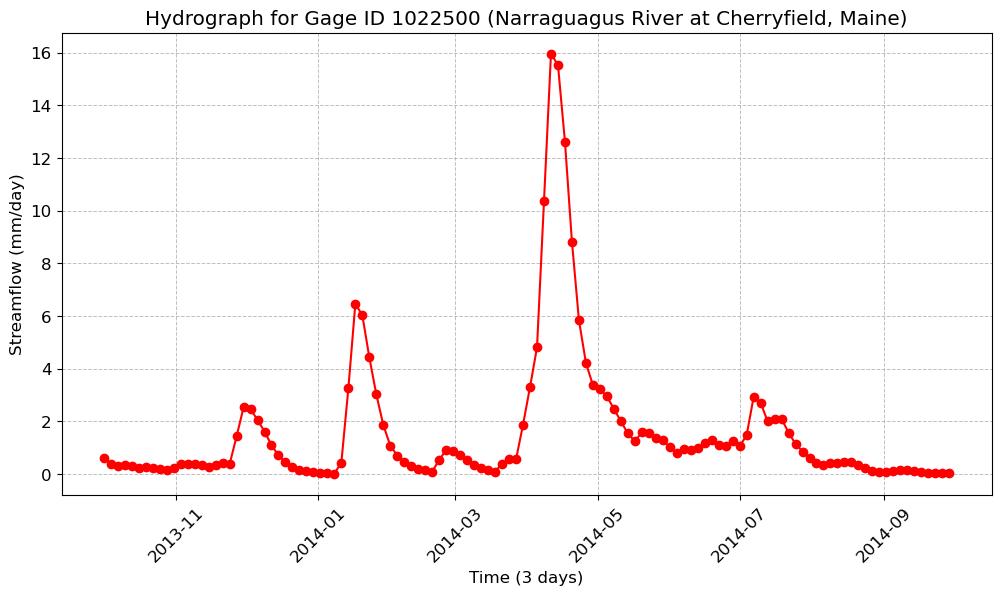

In [13]:
import numpy as np
import pandas as pd  
from src.dmg.core.post import plot_hydrograph
from src.dmg.core.utils import Dates

#------------------------------------------#
# Choose a basin by USGS gage ID to plot.
GAGE_ID = 1022500 

# Resample to 3-day prediction. Options: 'D', 'W', 'M', 'Y'.
RESAMPLE = '3D' 
#------------------------------------------#

# 1. Get the streamflow predictions and daily timesteps of the prediction window.
pred = output['Hbv_1_1p']['streamflow']
timesteps = Dates(config['simulation'], config['delta_model']['rho']).batch_daily_time_range
timesteps = timesteps[config['delta_model']['phy_model']['warm_up']:]  # remove warm-up period
if config['observations']['name'] == 'camels_671':
    basin_idx = list(gage_ids).index(GAGE_ID) if GAGE_ID in gage_ids else None
elif config['observations']['name'] == 'camels_531':
    basin_idx = list(gage_ids_531).index(GAGE_ID) if GAGE_ID in gage_ids_subset else None
else:
    raise ValueError(f"Unsupported dataset: {config['observations']}")
    
# 2. Get the data for the chosen basin and plot.
streamflow_pred_basin = pred[:, basin_idx].squeeze()
gage_name = obtain_gage_name(GAGE_NAME_PATH, GAGE_ID)
plot_hydrograph(
    timesteps,
    streamflow_pred_basin,
    resample=RESAMPLE,
    title=f"Hydrograph for Gage ID {GAGE_ID} ({gage_name})",
    ylabel='Streamflow (mm/day)',
)


<br>

## 2. Train δHBV 1.1p 

- Train δHBV 1.1p with the code block below.
- If you have already trained data, skip this.
- If you have not trained data nor download pretrained data, you won't be able to accomplish Step 1!

**Note**
- The settings defined in the config `./generic_deltamodel/example/conf/config_dhbv_1_1p.yaml` are set to replicate benchmark performance.
- For model training, set `mode: train` in the config, or modify after config dict has been created (see below).
- An `./example/generic_deltamodel/output/` directory will be generated to store experiment and model files. This location can be adjusted by changing the *save_path* key in your config. 
- Default settings with 50 epochs, batch size of 100, and training window from 1 October 1999 to 30 September 2008 should use ~2.8GB of vram. Expect training times of ~9 hours with an Nvidia RTX 3090 Ti.

In [ ]:
import sys
sys.path.append('../../')

from dmg import ModelHandler
from dmg.core.utils import (import_data_loader, import_trainer, print_config,
                            set_randomseed)
from example import load_config

#------------------------------------------#
# Define model settings here.
CONFIG_PATH = '../example/conf/config_dhbv_1_1p.yaml'
#------------------------------------------#

# 0. zhennan added --- tiny tee: mirror all prints/progress to train.log ---
from tqdm import tqdm
import sys

# tqdm writes to stderr by default; redirect to file also
logfile = open("train_progress.log", "a", buffering=1)

class TqdmLogger(object):
    def __init__(self, *files): self.files = files
    def write(self, x):
        for f in self.files:
            f.write(x)
            f.flush()
    def flush(self):
        for f in self.files: f.flush()

sys.stderr = TqdmLogger(sys.stderr, logfile)  # capture tqdm progress bar


# 1. Load configuration dictionary of model parameters and options.
config = load_config(CONFIG_PATH)
config['mode'] = 'train'
print_config(config)

# Set random seed for reproducibility.
set_randomseed(config['random_seed'])

# 2. Initialize the differentiable HBV 1.1p model (LSTM + HBV 1.1p) with model handler.
model = ModelHandler(config, verbose=True)

# 3. Load and initialize a dataset dictionary of NN and HBV model inputs.
data_loader_cls = import_data_loader(config['data_loader'])
data_loader = data_loader_cls(config, test_split=True, overwrite=False)


# 4. Initialize trainer to handle model training.
trainer_cls = import_trainer(config['trainer'])
trainer = trainer_cls(
    config,
    model,
    train_dataset=data_loader.train_dataset,
)

# 5. Start model training.
trainer.train()
print(f'Training complete. Model saved to \n{config['model_path']}')


Current Configuration
  Experiment Mode:    train               
  Model 1:            Hbv_1_1p            

Data Loader
  Data Source:        camels_531          
  Train Range :       1999/10/01          2008/09/30          

Model Parameters
  Train Epochs:       100                 Batch Size:         100                 
  Dropout:            0.5                 Hidden Size:        256                 
  Warmup:             365                 Concurrent Models:  16                  
  Loss Fn:            NseBatchLoss        

Machine
  Use Device:         cuda:0              



Epoch 1/100:  37%|###7      | 72/194 [06:04<10:11,  5.01s/it]

## 3. Evaluate Model Performance

After completing the training in [Section 1](#1-train-δhbv-11p), or with the trained model provided, test δHBV 1.1p below on the evaluation data.

**Note**
- For model evaluation, set `mode: test` in the config, or modify after config dict has been created (see below).
- When evaluating provided models, confirm that `test.test_epoch` in the config corresponds the training epochs completed for the model you want to test (e.g., 50 or 100).
- Default settings with 50 epochs, batch size of 25, and testing window from 1 October 1989 to 30 September 1999 should use ~2.7GB of VRAM. Expect evalutation times of ~5 minutes with an Nvidia RTX 3090 Ti.

### 3.1 Streamflow Simulation

In [14]:
import sys
sys.path.append('../../')

from dmg import ModelHandler
from dmg.core.utils import import_data_loader, import_trainer, print_config
from example import load_config

#------------------------------------------#
# Define model settings here.
CONFIG_PATH = '../example/conf/config_dhbv_1_1p.yaml'
#------------------------------------------#


# 1. Load configuration dictionary of model parameters and options.
config = load_config(CONFIG_PATH)
config['mode'] = 'test'
print_config(config)

set_randomseed(config['random_seed'])

# 2. Initialize the differentiable HBV 1.1p model (LSTM + HBV 1.1p).
model = ModelHandler(config, verbose=True)

# 3. Load and initialize a dataset dictionary of NN and HBV model inputs.
data_loader_cls = import_data_loader(config['data_loader'])
data_loader = data_loader_cls(config, test_split=True, overwrite=False)

# 4. Initialize trainer to handle model evaluation.
trainer_cls = import_trainer(config['trainer'])
trainer = trainer_cls(
    config,
    model,
    eval_dataset=data_loader.eval_dataset,
    verbose=True,
)

# 5. Start testing the model.
print('Evaluating model...')
trainer.evaluate()
print(f'Metrics and predictions saved to \n{config['out_path']}')


Current Configuration
  Experiment Mode:    test                
  Model 1:            Hbv_1_1p            

Data Loader
  Data Source:        camels_531          
  Test Range :        1989/10/01          1999/09/30          

Model Parameters
  Train Epochs:       50                  Batch Size:         100                 
  Dropout:            0.5                 Hidden Size:        256                 
  Warmup:             365                 Concurrent Models:  16                  
  Loss Fn:            NseBatchLoss        

Machine
  Use Device:         cuda:0              

./output/camels_531/train1999-2008/no_multi/CudnnLstmModel_E50_R365_B100_H256_n16_noLn_noWU_111111/Hbv_1_1p/NseBatchLoss/3dyn/parBETA_parK0_parBETAET/dHbv_1_1p_Ep50.pt is found for model Hbv_1_1p.
bfajnfdankdf
Evaluating model...


Metrics and predictions saved to 
./output/camels_531/train1999-2008/no_multi/CudnnLstmModel_E50_R365_B100_H256_n16_noLn_noWU_111111/Hbv_1_1p/NseBatchLoss/3dyn/parBETA_parK0_parBETAET/test1989-1999_Ep50


### 3.2 Visualize Trained Model Performance

Once the model has been evaluated, a new directory (e.g., for a model trained for 50 epochs and tested from years 1989-1999), `test1989-1999_ep50/`, will be created in the same directory containing the model files. This path will be populated with...

1. All model outputs (fluxes, states), including the target variable, *streamflow* (`streamflow.npy`),

2. `streamflow_obs.npy`, streamflow observation data for comparison against model predictions,

2. `metrics.json`, containing evaluation metrics accross the test time range for every gage in the dataset,

3. `metrics_agg.json`, containing evaluation metric statistics across all sites (mean, median, standard deviation).

We can use these outputs to visualize δHBV 1.1p's performance with a 
1. Cumulative distribution function (CDF) plot, 

2. CONUS map of gage locations and metric (e.g., NSE) performance.

<br>

But first, let's first check the (basin-)aggregated metrics for NSE, KGE, bias, RMSE, and, for both high/low flow regimes, RMSE and absolute percent bias...

In [16]:
import os

from dmg.core.data import load_json
from dmg.core.post import print_metrics


print(f"Evaluation output files saved to: {config['out_path']} \n")

# 1. Load the basin-aggregated evaluation results.
metrics_path = os.path.join(config['out_path'], 'metrics_agg.json')
metrics = load_json(metrics_path)
print(f"Available metrics: {metrics.keys()} \n")

# 2. Print the evaluation results.
metric_names =  [
    # Choose metrics to show.
    'nse', 'kge', 'bias', 'rmse', 'rmse_low', 'rmse_high', 'flv_abs', 'fhv_abs',
]
print_metrics(metrics, metric_names, mode='median', precision=3)

Evaluation output files saved to: ./output/camels_531/train1999-2008/no_multi/CudnnLstmModel_E50_R365_B100_H256_n16_noLn_noWU_111111/Hbv_1_1p/NseBatchLoss/3dyn/parBETA_parK0_parBETAET/test1989-1999_Ep50 

Available metrics: dict_keys(['bias', 'bias_rel', 'rmse', 'rmse_ub', 'rmse_fdc', 'mae', 'corr', 'corr_spearman', 'r2', 'nse', 'flv', 'fhv', 'pbias', 'pbias_mid', 'flv_abs', 'fhv_abs', 'pbias_abs', 'pbias_abs_mid', 'kge', 'kge_12', 'rmse_low', 'rmse_mid', 'rmse_high', 'd_max', 'd_max_rel']) 

Median of Metrics (Prec: 3 digits):
----------------------------------------
Nse: 0.754
Kge: 0.748
Bias: 0.488
Rmse: 1.211
Rmse_low: 0.061
Rmse_high: 3.548
Flv_abs: 43.383
Fhv_abs: 17.803
----------------------------------------


### 3.3 CDF Plot

The cumulative distribution function (CDF) plot tells us what percentage (CDF on the y-axis) of basins performed at least better than a given metric on the evaluation data.

An example is given below for NSE, but you can change to your preferred metric (see the output from the previous cell), but note some may require changing *xbounds* in `plot_cdf()`.

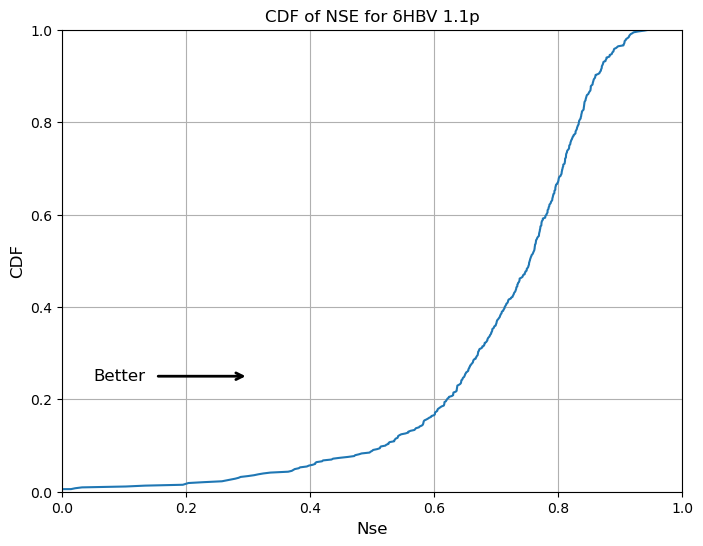

In [17]:
from dmg.core.post import plot_cdf

#------------------------------------------#
# Choose the metric to plot. (See available metrics printed above, or in the metrics_agg.json file).
METRIC = 'nse'
#------------------------------------------#


# 1. Load the evaluation metrics.
metrics_path = os.path.join(config['out_path'], 'metrics.json')
metrics = load_json(metrics_path)

# 2. Plot the CDF for NSE.
plot_cdf(
    metrics=[metrics],
    metric_names=[METRIC],
    model_labels=['δHBV 1.1p'],
    title="CDF of NSE for δHBV 1.1p",
    xlabel=METRIC.capitalize(),
    figsize=(8, 6),
    xbounds=(0, 1),
    ybounds=(0, 1),
    show_arrow=True,
)

### 3.4 Spatial Plot

This plot shows the locations of each basin in the evaluation data, color-coded by performance on a metric. Here we give a plot for NSE, but as before, this can be changed to your preference. (See above; for metrics not valued between 0 and 1, you will need to set `dynamic_colorbar=True` in `geoplot_single_metric` to ensure proper coding.)

Note, you will need to add paths to the CAMELS shapefile, gage IDs, and 531-gage subset which can be found in the [CAMELS download](#before-running).

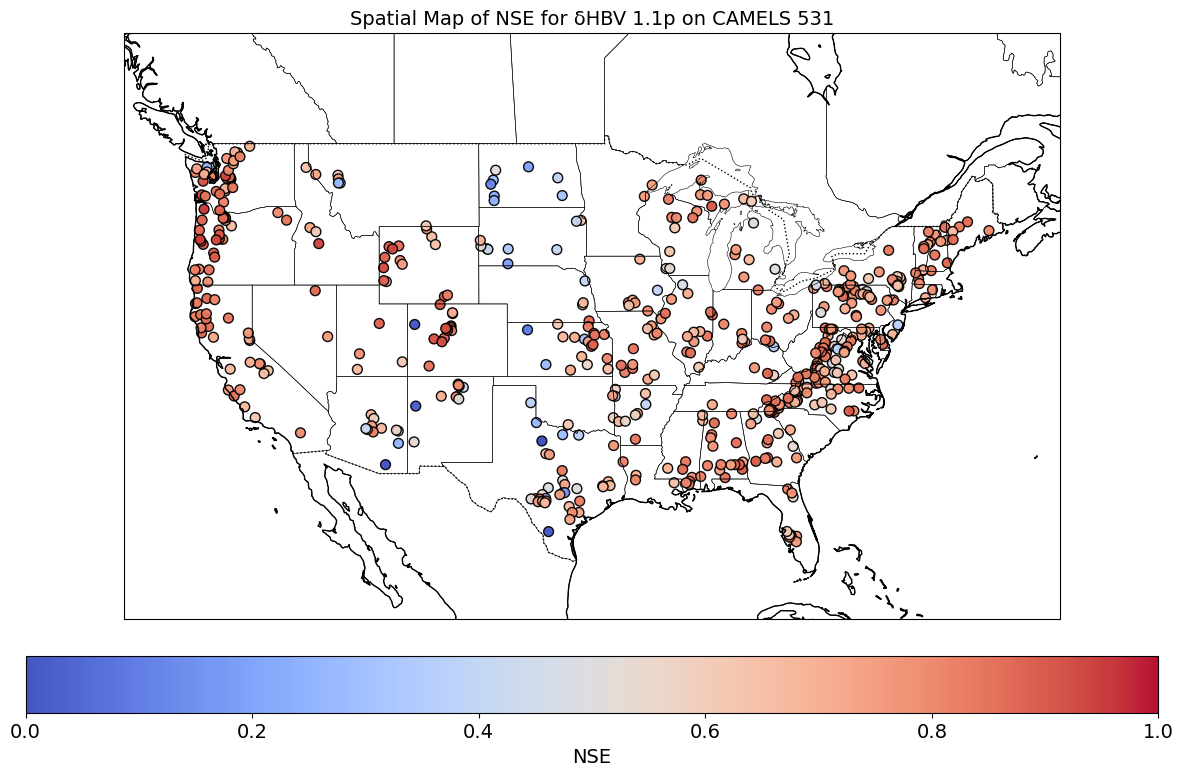

In [18]:
import geopandas as gpd
import numpy as np
import pandas as pd

from dmg.core.data import txt_to_array
from dmg.core.post import geoplot_single_metric

#------------------------------------------#
# Choose the metric to plot. (See available metrics printed above, or in the metrics_agg.json file).
METRIC = 'nse'

# Set the paths to the gage id lists and shapefiles...
GAGE_ID_PATH = config['observations']['gage_info']  #./gage_id.npy
GAGE_ID_531_PATH = config['observations']['subset_path']  #./531sub_id.txt
SHAPEFILE_PATH = '/beegfs/scratch/zhennanshi/DM/generic_deltamodel/extra_files_zhennan/camels_loc/camels_671_loc.shp' ## zhennan added to his directory

#------------------------------------------#


# 1. Load gage ids + basin shapefile with geocoordinates (lat, long) for every gage.
gage_ids = np.load(GAGE_ID_PATH, allow_pickle=True)
gage_ids_subset = txt_to_array(GAGE_ID_531_PATH)
coords = gpd.read_file(SHAPEFILE_PATH)

# 2. Format geocoords for 531- and 671-basin CAMELS sets.
coords_531 = coords[coords['gage_id'].isin(list(gage_ids_subset))].copy()

coords['gage_id'] = pd.Categorical(coords['gage_id'], categories=list(gage_ids), ordered=True)
coords_531['gage_id'] = pd.Categorical(coords_531['gage_id'], categories=list(gage_ids_subset), ordered=True)

coords = coords.sort_values('gage_id')  # Sort to match order of metrics.
basin_coords_531 = coords_531.sort_values('gage_id')

# 3. Load the evaluation metrics.
metrics_path = os.path.join(config['out_path'], 'metrics.json')
metrics = load_json(metrics_path)

# 4. Add the evaluation metrics to the basin shapefile.
if config['observations']['name'] == 'camels_671':
    coords[METRIC] = metrics[METRIC]
    full_data = coords
elif config['observations']['name'] == 'camels_531':
    coords_531[METRIC] = metrics[METRIC]
    full_data = coords_531
else:
    raise ValueError(f"Observation data supported: 'camels_671' or 'camels_531'. Got: {config['observations']}")

# 5. Plot the evaluation results spatially.
geoplot_single_metric(
    full_data,
    METRIC,
    rf"Spatial Map of {METRIC.upper()} for δHBV 1.1p on CAMELS " \
        f"{config['observations']['name'].split('_')[-1]}",
    dynamic_colorbar=False,
)